In [305]:
import pandas as pd

# Load the embeddings CSV
df = pd.read_csv("author_embeddings.csv")
df = df.drop(columns=['id'])
df.head()

,agreeableness,conscientiousness,extraversion,neuroticism,openness,embed_0,embed_1,embed_2,embed_3,embed_4,...,embed_758,embed_759,embed_760,embed_761,embed_762,embed_763,embed_764,embed_765,embed_766,embed_767
0,0.00,0.96,0.60,0.01,0.99,0.9595,-0.4644,1.1480,-0.4001,-0.3318,...,0.23740,0.7150,-0.2229,0.4321,0.4968,0.10120,-0.1594,-0.5864,0.2993,-0.2769
1,0.39,0.01,0.18,0.04,0.92,0.9380,-0.3823,0.9233,-0.6143,-0.3318,...,0.08840,0.6895,-0.3564,0.4604,0.4546,0.07385,-0.3535,-0.8590,0.3374,-0.3872
2,0.50,0.15,0.50,0.30,0.85,0.8810,-0.2186,0.7993,-0.6733,-0.2903,...,0.03223,0.6387,-0.4248,0.4310,0.3950,0.12760,-0.3810,-0.8770,0.3540,-0.3818
3,0.50,0.50,0.85,0.50,0.85,0.9070,-0.2954,0.8220,-0.7026,-0.2880,...,0.05063,0.7130,-0.3980,0.4973,0.4230,0.05405,-0.3820,-0.8945,0.3687,-0.3972
4,0.60,0.45,0.10,0.47,0.67,0.9310,-0.3950,0.9727,-0.6330,-0.3047,...,0.10614,0.7380,-0.3538,0.5356,0.4840,0.02553,-0.2664,-0.7820,0.3804,-0.3560


In [ ]:
### using training set only ###

In [307]:
# Assuming embedding columns are named like emb_0, emb_1, ..., emb_767
embedding_cols = [col for col in df.columns if col.startswith("embed_")]

X = df[embedding_cols]
y = df[["agreeableness", "conscientiousness", "extraversion", "neuroticism", "openness"]]

# Optional: convert scores to categories if still in [0, 1]
def convert(score):
    scaled = score * 100
    if scaled <= 32:
        return "low"
    elif scaled <= 66:
        return "medium"
    else:
        return "high"

for trait in y.columns:
    y[trait] = y[trait].apply(convert)


/var/folders/p2/c82btqsj0px4zkt04h9709yw0000gn/T/ipykernel_56318/3189409362.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[trait] = y[trait].apply(convert)


In [27]:
X.shape, y.shape

((1568, 768), (1568, 5))

In [ ]:
### regular 80/20 split ###

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train one classifier per trait
models = {}
for trait in y.columns:
    model = LogisticRegression(max_iter=5000)
    model.fit(X_train, y_train[trait])
    models[trait] = model

    # Evaluate
    preds = model.predict(X_val)
    print(f"\n--- {trait.upper()} ---")
    print(classification_report(y_val[trait], preds))



--- AGREEABLENESS ---
              precision    recall  f1-score   support

        high       0.31      0.21      0.25        94
         low       0.46      0.76      0.57       137
      medium       0.33      0.10      0.15        83

    accuracy                           0.42       314
   macro avg       0.37      0.36      0.33       314
weighted avg       0.38      0.42      0.37       314


--- CONSCIENTIOUSNESS ---
              precision    recall  f1-score   support

        high       0.38      0.13      0.19        85
         low       0.51      0.82      0.63       146
      medium       0.29      0.18      0.22        83

    accuracy                           0.46       314
   macro avg       0.39      0.38      0.35       314
weighted avg       0.42      0.46      0.40       314


--- EXTRAVERSION ---
              precision    recall  f1-score   support

        high       0.31      0.17      0.22        65
         low       0.58      0.88      0.69       169
   

In [ ]:
### using train data cross validation (may need to reoload the df from the beggining to abort any changes made) ###

In [309]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np

# Use StratifiedKFold for classification tasks
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Train and cross-validate one classifier per trait
models = {}

for trait in y.columns:
    print(f"\n=== {trait.upper()} ===")
    
    model = LogisticRegression(max_iter=5000)

    # Use cross_val_predict to get predictions from cross-validation
    preds = cross_val_predict(model, X, y[trait], cv=cv)

    # Optional: Fit the model on the whole data if you want to keep it for later
    model.fit(X, y[trait])
    models[trait] = model

    # Report classification results
    print(classification_report(y[trait], preds))



=== AGREEABLENESS ===
              precision    recall  f1-score   support

        high       0.41      0.26      0.32       433
         low       0.50      0.79      0.61       716
      medium       0.20      0.07      0.11       419

    accuracy                           0.45      1568
   macro avg       0.37      0.37      0.35      1568
weighted avg       0.39      0.45      0.40      1568


=== CONSCIENTIOUSNESS ===
              precision    recall  f1-score   support

        high       0.33      0.12      0.17       376
         low       0.51      0.83      0.63       749
      medium       0.33      0.16      0.21       443

    accuracy                           0.47      1568
   macro avg       0.39      0.37      0.34      1568
weighted avg       0.42      0.47      0.40      1568


=== EXTRAVERSION ===
              precision    recall  f1-score   support

        high       0.33      0.15      0.20       337
         low       0.56      0.86      0.68       823
   

In [311]:
### only logistic regression ###

/var/folders/p2/c82btqsj0px4zkt04h9709yw0000gn/T/ipykernel_56318/1123733678.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[trait] = y_train[trait].apply(convert_100)
/var/folders/p2/c82btqsj0px4zkt04h9709yw0000gn/T/ipykernel_56318/1123733678.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_val[trait] = y_val[trait].apply(convert)



=== Trait: AGREEABLENESS ===
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        24
         low       0.00      0.00      0.00         5
      medium       0.09      1.00      0.17         3

    accuracy                           0.09        32
   macro avg       0.03      0.33      0.06        32
weighted avg       0.01      0.09      0.02        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


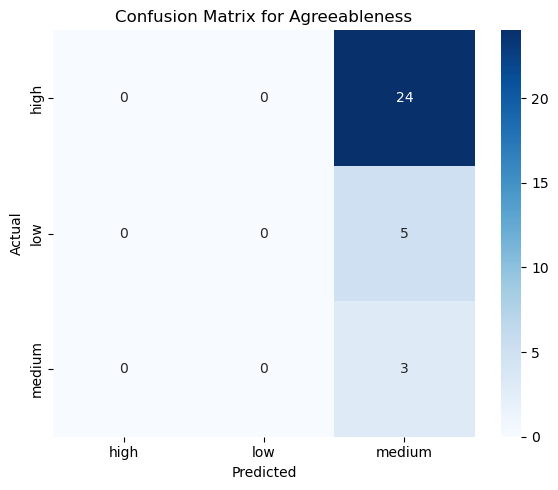


=== Trait: CONSCIENTIOUSNESS ===
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.75      0.15      0.25        20
      medium       0.19      0.83      0.30         6

    accuracy                           0.25        32
   macro avg       0.31      0.33      0.18        32
weighted avg       0.50      0.25      0.21        32



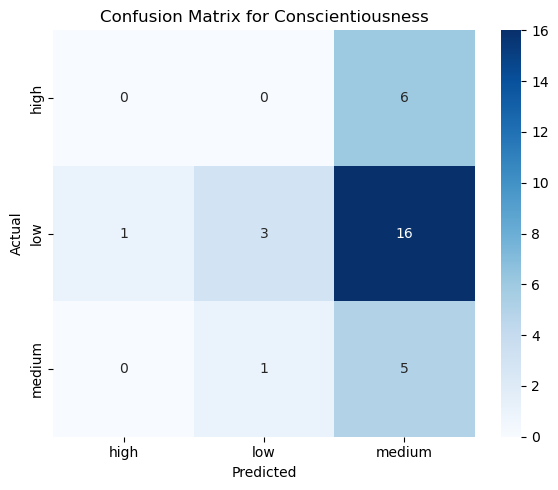


=== Trait: EXTRAVERSION ===
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        10
         low       0.41      1.00      0.58        13
      medium       0.00      0.00      0.00         9

    accuracy                           0.41        32
   macro avg       0.14      0.33      0.19        32
weighted avg       0.17      0.41      0.23        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


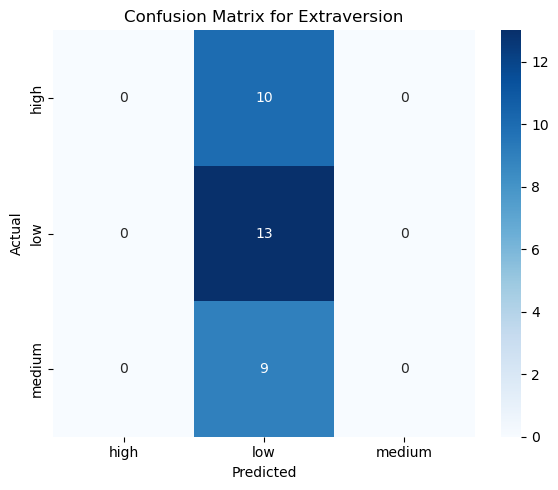


=== Trait: NEUROTICISM ===
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         4
         low       0.00      0.00      0.00        13
      medium       0.47      1.00      0.64        15

    accuracy                           0.47        32
   macro avg       0.16      0.33      0.21        32
weighted avg       0.22      0.47      0.30        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


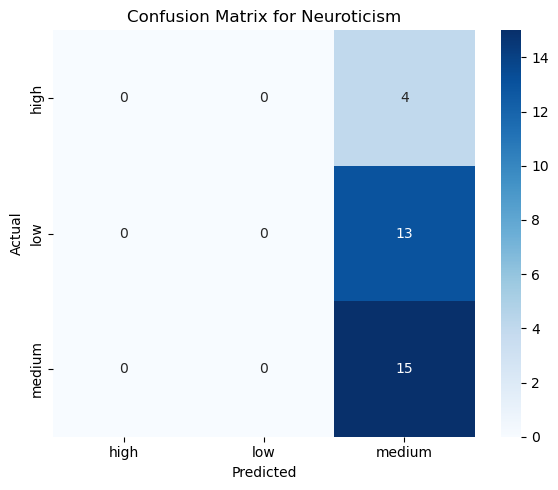


=== Trait: OPENNESS ===
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        20
         low       0.25      1.00      0.40         8
      medium       0.00      0.00      0.00         4

    accuracy                           0.25        32
   macro avg       0.08      0.33      0.13        32
weighted avg       0.06      0.25      0.10        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


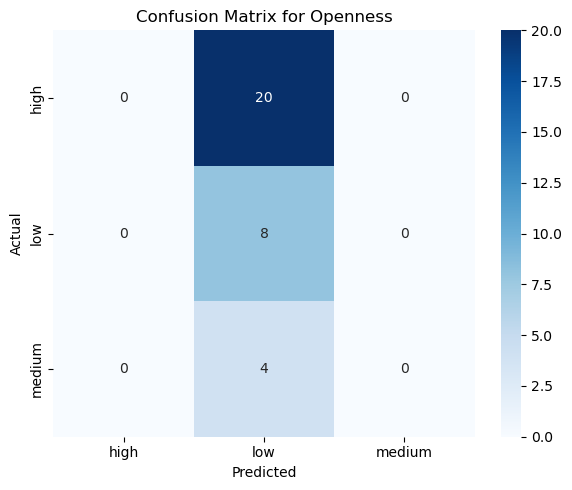

In [313]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Load pre-embedded training and validation data
train_df = pd.read_csv("author_embeddings.csv").drop(columns=['id'])
val_df = pd.read_csv("val_data_embeddings_filtered.csv") #this is the val data set embedding withoug the texts and id

# Identify embedding columns
embedding_cols = [col for col in train_df.columns if col.startswith("embed_")]

# Extract X and y for training
X_train = train_df[embedding_cols]
y_train = train_df[["agreeableness", "conscientiousness", "extraversion", "neuroticism", "openness"]]

# Extract X and y for validation
X_val = val_df[embedding_cols]
y_val = val_df[["agreeableness", "conscientiousness", "extraversion", "neuroticism", "openness"]]

# Convert trait scores to "low", "medium", "high"
def convert_100(score): #for train 
    scaled = score * 100
    if scaled <= 32:
        return "low"
    elif scaled <= 66:
        return "medium"
    else:
        return "high"

def convert(score): #for val 
    if score <= 32:
        return "low"
    elif score <= 66:
        return "medium"
    else:
        return "high"

for trait in y_train.columns:
    y_train[trait] = y_train[trait].apply(convert_100)

for trait in y_val.columns:
    y_val[trait] = y_val[trait].apply(convert)

# Train and evaluate a classifier per trait
for trait in y_train.columns:
    print(f"\n=== Trait: {trait.upper()} ===")
    
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train[trait])
    y_val_enc = le.transform(y_val[trait])
    
    # Train classifier
    clf = LogisticRegression(max_iter=5000, class_weight="balanced")
    clf.fit(X_train, y_train_enc)

    # Predict on validation set
    y_pred = clf.predict(X_val)

    # Report results
    print(classification_report(y_val_enc, y_pred, target_names=le.classes_))

    # Plot confusion matrix
    cm = confusion_matrix(y_val_enc, y_pred)
    cm_labels = le.classes_

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {trait.title()}")
    plt.tight_layout()
    plt.show()


In [ ]:
### using linear regression ###


=== Trait: AGREEABLENESS ===
              precision    recall  f1-score   support

        high       0.72      0.75      0.73        24
         low       0.00      0.00      0.00         5
      medium       0.00      0.00      0.00         3

    accuracy                           0.56        32
   macro avg       0.24      0.25      0.24        32
weighted avg       0.54      0.56      0.55        32



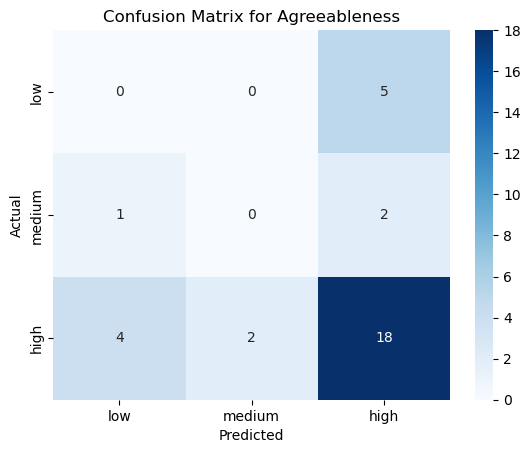


=== Trait: CONSCIENTIOUSNESS ===
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.62      1.00      0.77        20
      medium       0.00      0.00      0.00         6

    accuracy                           0.62        32
   macro avg       0.21      0.33      0.26        32
weighted avg       0.39      0.62      0.48        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


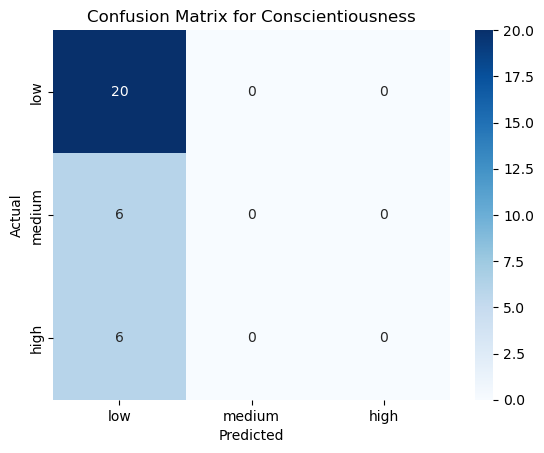


=== Trait: EXTRAVERSION ===
              precision    recall  f1-score   support

        high       0.18      0.20      0.19        10
         low       0.45      0.69      0.55        13
      medium       0.00      0.00      0.00         9

    accuracy                           0.34        32
   macro avg       0.21      0.30      0.25        32
weighted avg       0.24      0.34      0.28        32



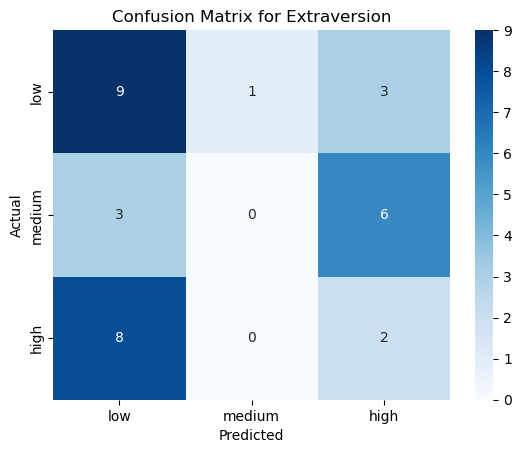


=== Trait: NEUROTICISM ===
              precision    recall  f1-score   support

        high       0.13      1.00      0.23         4
         low       1.00      0.08      0.14        13
      medium       0.00      0.00      0.00        15

    accuracy                           0.16        32
   macro avg       0.38      0.36      0.12        32
weighted avg       0.42      0.16      0.09        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


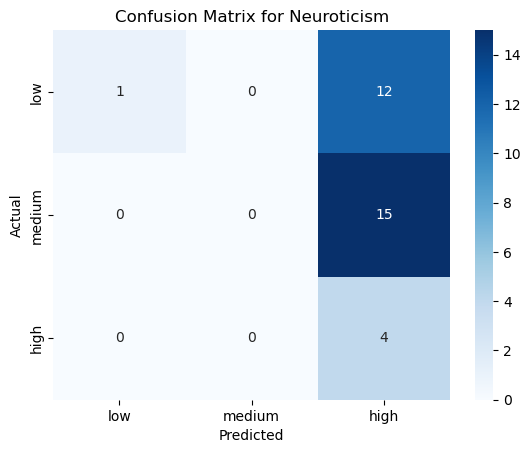


=== Trait: OPENNESS ===
              precision    recall  f1-score   support

        high       0.67      0.60      0.63        20
         low       0.21      0.38      0.27         8
      medium       0.00      0.00      0.00         4

    accuracy                           0.47        32
   macro avg       0.29      0.33      0.30        32
weighted avg       0.47      0.47      0.46        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


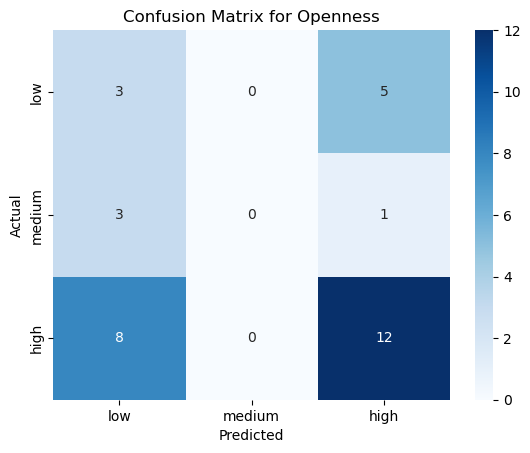

In [319]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

train_df = pd.read_csv("author_embeddings.csv").drop(columns=['id'])
val_df = pd.read_csv("val_data_embeddings_filtered.csv")


# Identify embedding columns
embedding_cols = [col for col in train_df.columns if col.startswith("embed_")]
# Define trait columns
traits = ["agreeableness", "conscientiousness", "extraversion", "neuroticism", "openness"]


# Prepare train/val X and y
X_train = train_df[embedding_cols]
X_val = val_df[embedding_cols]
y_train = train_df[traits]
y_val = val_df[traits]

# Convert trait scores to "low", "medium", "high"
def convert_100(score): #for train 
    scaled = score * 100
    if scaled <= 32:
        return "low"
    elif scaled <= 66:
        return "medium"
    else:
        return "high"

def convert(score): #for val 
    if score <= 32:
        return "low"
    elif score <= 66:
        return "medium"
    else:
        return "high"
        
# Loop over traits
for trait in traits:
    print(f"\n=== Trait: {trait.upper()} ===")

    # Train regression model
    reg = LinearRegression()
    reg.fit(X_train, y_train[trait])

    # Predict on validation set
    y_pred_cont = reg.predict(X_val)

    # Convert to categories
    y_pred_cat = pd.Series(y_pred_cont).apply(convert_100)
    y_true_cat = y_val[trait].apply(convert)

    # Report classification results
    print(classification_report(y_true_cat, y_pred_cat))

    # Plot confusion matrix
    cm = confusion_matrix(y_true_cat, y_pred_cat, labels=["low", "medium", "high"])
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["low", "medium", "high"], yticklabels=["low", "medium", "high"], cmap="Blues")
    plt.title(f"Confusion Matrix for {trait.capitalize()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
### comparing models ###

In [321]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

models = {
    "LogReg": LogisticRegression(max_iter=5000),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC()
}

for trait in traits:
    print(f"\n=== Trait: {trait.upper()} ===")
    
    y_train_trait = y_train[trait].apply(convert_100)
    y_val_trait = y_val[trait].apply(convert)

    for name, model in models.items():
        model.fit(X_train, y_train_trait)
        y_pred = model.predict(X_val)

        print(f"\n--- {name} ---")
        print(classification_report(y_val_trait, y_pred))



=== Trait: AGREEABLENESS ===

--- LogReg ---
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        24
         low       0.00      0.00      0.00         5
      medium       0.09      1.00      0.17         3

    accuracy                           0.09        32
   macro avg       0.03      0.33      0.06        32
weighted avg       0.01      0.09      0.02        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- RandomForest ---
              precision    recall  f1-score   support

        high       1.00      0.04      0.08        24
         low       0.12      0.40      0.18         5
      medium       0.14      0.67      0.24         3

    accuracy                           0.16        32
   macro avg       0.42      0.37      0.17        32
weighted avg       0.78      0.16      0.11        32


--- SVM ---
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        24
         low       0.16      1.00      0.27         5
      medium       0.00      0.00      0.00         3

    accuracy                           0.16        32
   macro avg       0.05      0.33      0.09        32
weighted avg       0.02      0.16      0.04        32


=== Trait: CONSCIENTIOUSNESS ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- LogReg ---
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.62      0.25      0.36        20
      medium       0.17      0.67      0.28         6

    accuracy                           0.28        32
   macro avg       0.27      0.31      0.21        32
weighted avg       0.42      0.28      0.27        32


--- RandomForest ---
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.60      0.90      0.72        20
      medium       0.00      0.00      0.00         6

    accuracy                           0.56        32
   macro avg       0.20      0.30      0.24        32
weighted avg       0.38      0.56      0.45        32


--- SVM ---
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.62      1.00      0.77        20
      medium       0.00 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- LogReg ---
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        10
         low       0.41      1.00      0.58        13
      medium       0.00      0.00      0.00         9

    accuracy                           0.41        32
   macro avg       0.14      0.33      0.19        32
weighted avg       0.17      0.41      0.23        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- RandomForest ---
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        10
         low       0.43      0.92      0.59        13
      medium       0.00      0.00      0.00         9

    accuracy                           0.38        32
   macro avg       0.14      0.31      0.20        32
weighted avg       0.17      0.38      0.24        32


--- SVM ---
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        10
         low       0.41      1.00      0.58        13
      medium       0.00      0.00      0.00         9

    accuracy                           0.41        32
   macro avg       0.14      0.33      0.19        32
weighted avg       0.17      0.41      0.23        32


=== Trait: NEUROTICISM ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- LogReg ---
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         4
         low       0.00      0.00      0.00        13
      medium       0.47      1.00      0.64        15

    accuracy                           0.47        32
   macro avg       0.16      0.33      0.21        32
weighted avg       0.22      0.47      0.30        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- RandomForest ---
              precision    recall  f1-score   support

        high       0.12      1.00      0.22         4
         low       0.00      0.00      0.00        13
      medium       0.00      0.00      0.00        15

    accuracy                           0.12        32
   macro avg       0.04      0.33      0.07        32
weighted avg       0.02      0.12      0.03        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- SVM ---
              precision    recall  f1-score   support

        high       0.12      1.00      0.22         4
         low       0.00      0.00      0.00        13
      medium       0.00      0.00      0.00        15

    accuracy                           0.12        32
   macro avg       0.04      0.33      0.07        32
weighted avg       0.02      0.12      0.03        32


=== Trait: OPENNESS ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- LogReg ---
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        20
         low       0.25      1.00      0.40         8
      medium       0.00      0.00      0.00         4

    accuracy                           0.25        32
   macro avg       0.08      0.33      0.13        32
weighted avg       0.06      0.25      0.10        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- RandomForest ---
              precision    recall  f1-score   support

        high       0.58      0.75      0.65        20
         low       0.17      0.12      0.14         8
      medium       0.00      0.00      0.00         4

    accuracy                           0.50        32
   macro avg       0.25      0.29      0.27        32
weighted avg       0.40      0.50      0.44        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



--- SVM ---
              precision    recall  f1-score   support

        high       0.62      1.00      0.77        20
         low       0.00      0.00      0.00         8
      medium       0.00      0.00      0.00         4

    accuracy                           0.62        32
   macro avg       0.21      0.33      0.26        32
weighted avg       0.39      0.62      0.48        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# AGREEABLENESS -random forest
# CONSCIENTIOUSNESS - svm
# EXTRAVERSION - random forest = svm
# NEUROTICISM - log reg
# OPENNESS - svm 

In [ ]:
### using best performing model for each trait ###

In [275]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load pre-embedded training and validation data
train_df = pd.read_csv("author_embeddings.csv").drop(columns=['id'])
val_df = pd.read_csv("val_data_embeddings_filtered.csv")

# Identify embedding columns
embedding_cols = [col for col in train_df.columns if col.startswith("embed_")]

# Extract X and y for training
X_train = train_df[embedding_cols]
y_train = train_df[["agreeableness", "conscientiousness", "extraversion", "neuroticism", "openness"]]

# Extract X and y for validation
X_val = val_df[embedding_cols]
y_val = val_df[["agreeableness", "conscientiousness", "extraversion", "neuroticism", "openness"]]

# Convert [0,1] trait scores to "low", "medium", "high"
def convert_100(score): # for train
    scaled = score * 100
    if scaled <= 32:
        return "low"
    elif scaled <= 66:
        return "medium"
    else:
        return "high"

def convert(score): # for val
    if score <= 32:
        return "low"
    elif score <= 66:
        return "medium"
    else:
        return "high"

for trait in y_train.columns:
    y_train[trait] = y_train[trait].apply(convert_100)

for trait in y_val.columns:
    y_val[trait] = y_val[trait].apply(convert)

# Define classifiers for each trait
classifiers = {
    "agreeableness": RandomForestClassifier(),
    "conscientiousness": SVC(),
    "extraversion": RandomForestClassifier(),  # or SVC() = does slightly worse
    "neuroticism": LogisticRegression(max_iter=5000),
    "openness": SVC()
}

# Variables to store overall performance scores
f1_scores = []

# Train and evaluate a classifier per trait
for trait in y_train.columns:
    print(f"\n=== Trait: {trait.upper()} ===")
    
    # Encode labels
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train[trait])
    y_val_enc = le.transform(y_val[trait])
    
    # Train classifier for the specific trait
    clf = classifiers[trait]
    clf.fit(X_train, y_train_enc)

    # Predict on validation set
    y_pred = clf.predict(X_val)

    # Report results
    print(classification_report(y_val_enc, y_pred, target_names=le.classes_))
    
    # Calculate F1-score for this trait and store it
    f1 = f1_score(y_val_enc, y_pred, average='macro')
    f1_scores.append(f1)

# Calculate overall (macro-average) F1 score
overall_f1_score = np.mean(f1_scores)
print(f"\nOverall Macro-Average F1 Score: {overall_f1_score:.4f}")


/var/folders/p2/c82btqsj0px4zkt04h9709yw0000gn/T/ipykernel_56318/576667318.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[trait] = y_train[trait].apply(convert_100)
/var/folders/p2/c82btqsj0px4zkt04h9709yw0000gn/T/ipykernel_56318/576667318.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_val[trait] = y_val[trait].apply(convert)



=== Trait: AGREEABLENESS ===
              precision    recall  f1-score   support

        high       1.00      0.12      0.22        24
         low       0.00      0.00      0.00         5
      medium       0.14      1.00      0.24         3

    accuracy                           0.19        32
   macro avg       0.38      0.38      0.15        32
weighted avg       0.76      0.19      0.19        32


=== Trait: CONSCIENTIOUSNESS ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.62      1.00      0.77        20
      medium       0.00      0.00      0.00         6

    accuracy                           0.62        32
   macro avg       0.21      0.33      0.26        32
weighted avg       0.39      0.62      0.48        32


=== Trait: EXTRAVERSION ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        high       1.00      0.10      0.18        10
         low       0.42      1.00      0.59        13
      medium       0.00      0.00      0.00         9

    accuracy                           0.44        32
   macro avg       0.47      0.37      0.26        32
weighted avg       0.48      0.44      0.30        32


=== Trait: NEUROTICISM ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        high       0.00      0.00      0.00         4
         low       0.00      0.00      0.00        13
      medium       0.47      1.00      0.64        15

    accuracy                           0.47        32
   macro avg       0.16      0.33      0.21        32
weighted avg       0.22      0.47      0.30        32


=== Trait: OPENNESS ===
              precision    recall  f1-score   support

        high       0.62      1.00      0.77        20
         low       0.00      0.00      0.00         8
      medium       0.00      0.00      0.00         4

    accuracy                           0.62        32
   macro avg       0.21      0.33      0.26        32
weighted avg       0.39      0.62      0.48        32


Overall Macro-Average F1 Score: 0.2274


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
### let the dummy experiments begin ###

In [327]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report


# Load pre-embedded training and validation data
train_df = pd.read_csv("author_embeddings.csv").drop(columns=['id'])
val_df = pd.read_csv("val_data_embeddings_filtered.csv")

# Identify embedding columns
embedding_cols = [col for col in train_df.columns if col.startswith("embed_")]

# Extract X and y for training
X_train = train_df[embedding_cols]
y_train = train_df[["agreeableness", "conscientiousness", "extraversion", "neuroticism", "openness"]]

# Extract X and y for validation
X_val = val_df[embedding_cols]
y_val = val_df[["agreeableness", "conscientiousness", "extraversion", "neuroticism", "openness"]]

# Convert [0,1] trait scores to "low", "medium", "high"
def convert_100(score): # for train
    scaled = score * 100
    if scaled <= 32:
        return "low"
    elif scaled <= 66:
        return "medium"
    else:
        return "high"

def convert(score): # for val
    if score <= 32:
        return "low"
    elif score <= 66:
        return "medium"
    else:
        return "high"

for trait in y_train.columns:
    y_train[trait] = y_train[trait].apply(convert_100)

for trait in y_val.columns:
    y_val[trait] = y_val[trait].apply(convert)
    


# Train and evaluate model vs dummy for each trait
for trait in y_train.columns:
    print(f"\n=== {trait.upper()} ===")
    
    # Real model
    model = LogisticRegression(max_iter=5000)
    model.fit(X_train, y_train[trait])
    preds_model = model.predict(X_val)
    print("Logistic Regression:")
    print(classification_report(y_val[trait], preds_model))

    # Dummy baseline
    dummy = DummyClassifier(strategy="most_frequent") #frequent
    dummy.fit(X_train, y_train[trait])
    preds_dummy = dummy.predict(X_val)
    print("Dummy (Most Frequent):")
    print(classification_report(y_val[trait], preds_dummy))

## dummy does better more often than not :') ##


/var/folders/p2/c82btqsj0px4zkt04h9709yw0000gn/T/ipykernel_56318/814154015.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[trait] = y_train[trait].apply(convert_100)
/var/folders/p2/c82btqsj0px4zkt04h9709yw0000gn/T/ipykernel_56318/814154015.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_val[trait] = y_val[trait].apply(convert)



=== AGREEABLENESS ===
Logistic Regression:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        24
         low       0.00      0.00      0.00         5
      medium       0.09      1.00      0.17         3

    accuracy                           0.09        32
   macro avg       0.03      0.33      0.06        32
weighted avg       0.01      0.09      0.02        32

Dummy (Most Frequent):
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        24
         low       0.16      1.00      0.27         5
      medium       0.00      0.00      0.00         3

    accuracy                           0.16        32
   macro avg       0.05      0.33      0.09        32
weighted avg       0.02      0.16      0.04        32


=== CONSCIENTIOUSNESS ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/

Logistic Regression:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.62      0.25      0.36        20
      medium       0.17      0.67      0.28         6

    accuracy                           0.28        32
   macro avg       0.27      0.31      0.21        32
weighted avg       0.42      0.28      0.27        32

Dummy (Most Frequent):
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.62      1.00      0.77        20
      medium       0.00      0.00      0.00         6

    accuracy                           0.62        32
   macro avg       0.21      0.33      0.26        32
weighted avg       0.39      0.62      0.48        32


=== EXTRAVERSION ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        10
         low       0.41      1.00      0.58        13
      medium       0.00      0.00      0.00         9

    accuracy                           0.41        32
   macro avg       0.14      0.33      0.19        32
weighted avg       0.17      0.41      0.23        32

Dummy (Most Frequent):
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        10
         low       0.41      1.00      0.58        13
      medium       0.00      0.00      0.00         9

    accuracy                           0.41        32
   macro avg       0.14      0.33      0.19        32
weighted avg       0.17      0.41      0.23        32


=== NEUROTICISM ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/

Logistic Regression:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         4
         low       0.00      0.00      0.00        13
      medium       0.47      1.00      0.64        15

    accuracy                           0.47        32
   macro avg       0.16      0.33      0.21        32
weighted avg       0.22      0.47      0.30        32

Dummy (Most Frequent):
              precision    recall  f1-score   support

        high       0.12      1.00      0.22         4
         low       0.00      0.00      0.00        13
      medium       0.00      0.00      0.00        15

    accuracy                           0.12        32
   macro avg       0.04      0.33      0.07        32
weighted avg       0.02      0.12      0.03        32


=== OPENNESS ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/

Logistic Regression:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        20
         low       0.25      1.00      0.40         8
      medium       0.00      0.00      0.00         4

    accuracy                           0.25        32
   macro avg       0.08      0.33      0.13        32
weighted avg       0.06      0.25      0.10        32

Dummy (Most Frequent):
              precision    recall  f1-score   support

        high       0.62      1.00      0.77        20
         low       0.00      0.00      0.00         8
      medium       0.00      0.00      0.00         4

    accuracy                           0.62        32
   macro avg       0.21      0.33      0.26        32
weighted avg       0.39      0.62      0.48        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/

In [329]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report


# Load pre-embedded training and validation data
train_df = pd.read_csv("author_embeddings.csv").drop(columns=['id'])
val_df = pd.read_csv("val_data_embeddings_filtered.csv")

# Identify embedding columns
embedding_cols = [col for col in train_df.columns if col.startswith("embed_")]

# Extract X and y for training
X_train = train_df[embedding_cols]
y_train = train_df[["agreeableness", "conscientiousness", "extraversion", "neuroticism", "openness"]]

# Extract X and y for validation
X_val = val_df[embedding_cols]
y_val = val_df[["agreeableness", "conscientiousness", "extraversion", "neuroticism", "openness"]]

# Convert [0,1] trait scores to "low", "medium", "high"
def convert_100(score): # for train
    scaled = score * 100
    if scaled <= 32:
        return "low"
    elif scaled <= 66:
        return "medium"
    else:
        return "high"

def convert(score): # for val
    if score <= 32:
        return "low"
    elif score <= 66:
        return "medium"
    else:
        return "high"

for trait in y_train.columns:
    y_train[trait] = y_train[trait].apply(convert_100)

for trait in y_val.columns:
    y_val[trait] = y_val[trait].apply(convert)
    


# Train and evaluate model vs dummy for each trait
for trait in y_train.columns:
    print(f"\n=== {trait.upper()} ===")
    
    # Real model
    model = LogisticRegression(max_iter=5000)
    model.fit(X_train, y_train[trait])
    preds_model = model.predict(X_val)
    print("Logistic Regression:")
    print(classification_report(y_val[trait], preds_model))

    # Dummy baseline
    dummy = DummyClassifier(strategy="stratified")  # stratified
    dummy.fit(X_train, y_train[trait])
    preds_dummy = dummy.predict(X_val)
    print("Dummy (Most Frequent):")
    print(classification_report(y_val[trait], preds_dummy))

## dummy does better more often than not :') ##


/var/folders/p2/c82btqsj0px4zkt04h9709yw0000gn/T/ipykernel_56318/2172101344.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[trait] = y_train[trait].apply(convert_100)
/var/folders/p2/c82btqsj0px4zkt04h9709yw0000gn/T/ipykernel_56318/2172101344.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_val[trait] = y_val[trait].apply(convert)



=== AGREEABLENESS ===
Logistic Regression:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        24
         low       0.00      0.00      0.00         5
      medium       0.09      1.00      0.17         3

    accuracy                           0.09        32
   macro avg       0.03      0.33      0.06        32
weighted avg       0.01      0.09      0.02        32

Dummy (Most Frequent):
              precision    recall  f1-score   support

        high       0.89      0.33      0.48        24
         low       0.20      0.60      0.30         5
      medium       0.25      0.67      0.36         3

    accuracy                           0.41        32
   macro avg       0.45      0.53      0.38        32
weighted avg       0.72      0.41      0.44        32


=== CONSCIENTIOUSNESS ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         6
         low       0.62      0.25      0.36        20
      medium       0.17      0.67      0.28         6

    accuracy                           0.28        32
   macro avg       0.27      0.31      0.21        32
weighted avg       0.42      0.28      0.27        32

Dummy (Most Frequent):
              precision    recall  f1-score   support

        high       0.40      0.33      0.36         6
         low       0.61      0.55      0.58        20
      medium       0.22      0.33      0.27         6

    accuracy                           0.47        32
   macro avg       0.41      0.41      0.40        32
weighted avg       0.50      0.47      0.48        32


=== EXTRAVERSION ===
Logistic Regression:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        10
         low       0.41      1.00      0.5

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         4
         low       0.00      0.00      0.00        13
      medium       0.47      1.00      0.64        15

    accuracy                           0.47        32
   macro avg       0.16      0.33      0.21        32
weighted avg       0.22      0.47      0.30        32

Dummy (Most Frequent):
              precision    recall  f1-score   support

        high       0.00      0.00      0.00         4
         low       0.62      0.38      0.48        13
      medium       0.14      0.07      0.09        15

    accuracy                           0.19        32
   macro avg       0.26      0.15      0.19        32
weighted avg       0.32      0.19      0.24        32


=== OPENNESS ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00        20
         low       0.25      1.00      0.40         8
      medium       0.00      0.00      0.00         4

    accuracy                           0.25        32
   macro avg       0.08      0.33      0.13        32
weighted avg       0.06      0.25      0.10        32

Dummy (Most Frequent):
              precision    recall  f1-score   support

        high       0.62      0.65      0.63        20
         low       0.33      0.12      0.18         8
      medium       0.00      0.00      0.00         4

    accuracy                           0.44        32
   macro avg       0.32      0.26      0.27        32
weighted avg       0.47      0.44      0.44        32



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
